In [8]:
import os
import sys
from pathlib import Path
from functools import partial
from datetime import datetime

import scipy.optimize
import numpy as np
import matplotlib.pyplot as plt

# path hack to make relative imports work - don't mind me
__package__ = "src"
modulepath = Path.cwd().joinpath("../powerberry-app").resolve().as_posix()

if modulepath not in sys.path:
    sys.path.append(modulepath)

from .app import App
from .services.config import Config

In [ ]:
os.environ["CONFIG_PATH"] = Path.cwd().joinpath("../config/config.json").resolve().as_posix()

config = Config()
app = App(config)
app.connect()

In [ ]:
ts, volt = app._read_channel("0", "0")
ts = ts / 1_000_000

prefix = "xx"
np.save(f"./samples/{prefix}_ts.npy", ts)
np.save(f"./samples/{prefix}_volt.npy", volt)

In [41]:
prefix = "2022_09_22_heater"
ts2, volt2 = np.load(f"./samples/{prefix}_ts.npy"), np.load(f"./samples/{prefix}_volt.npy")
ts2 = ts2 / 1_000_000

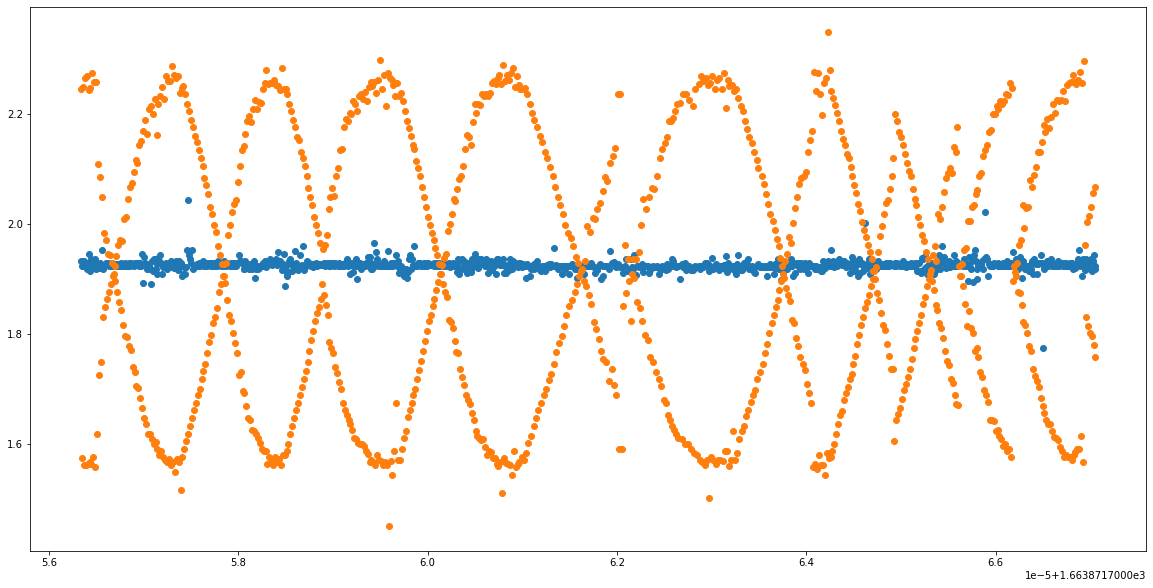

In [43]:
plt.figure(figsize=(20, 10))
plt.scatter(ts[:1000], volt[:1000])
plt.scatter(ts[:1000], volt2[:1000])
plt.show()

In [35]:
def fit_sinus(xs, ys, f0=50):
    # (c) https://stackoverflow.com/a/42322656

    xs = np.array(xs)
    ys = np.array(ys)

    def sin(t, A, w, p, c):
        return A * np.sin(w*t + p) + c

    # ff = np.fft.fftfreq(len(xs), (xs[1]-xs[0]))   # assume uniform spacing
    # Fyy = abs(np.fft.fft(ys))
    # guess_freq = abs(ff[np.argmax(Fyy[1:])+1])

    # guess a few parameters
    _A = 1.9 # np.std(volt) * 2.0**0.5
    _w = 2.0 * np.pi * f0
    _p = 0.0
    _c = 0.0 # np.mean(volt)
    guess = [_A, _w, _p, _c]

    # fit sinus with non-linear least squares
    popt, _ = scipy.optimize.curve_fit(sin, xs, ys, p0=guess)
    A, w, p, c = popt
    f = w / (2.0 * np.pi)

    print(f"{A=} {w=} ({f=}) {p=} {c=}")
    func = partial(sin, A=A, w=w, p=p, c=c)
    return func

A=3.704637740229917 w=314.96250451539845 (f=50.12783948222907) p=-1338.6260081213663 c=-1.777756998737101


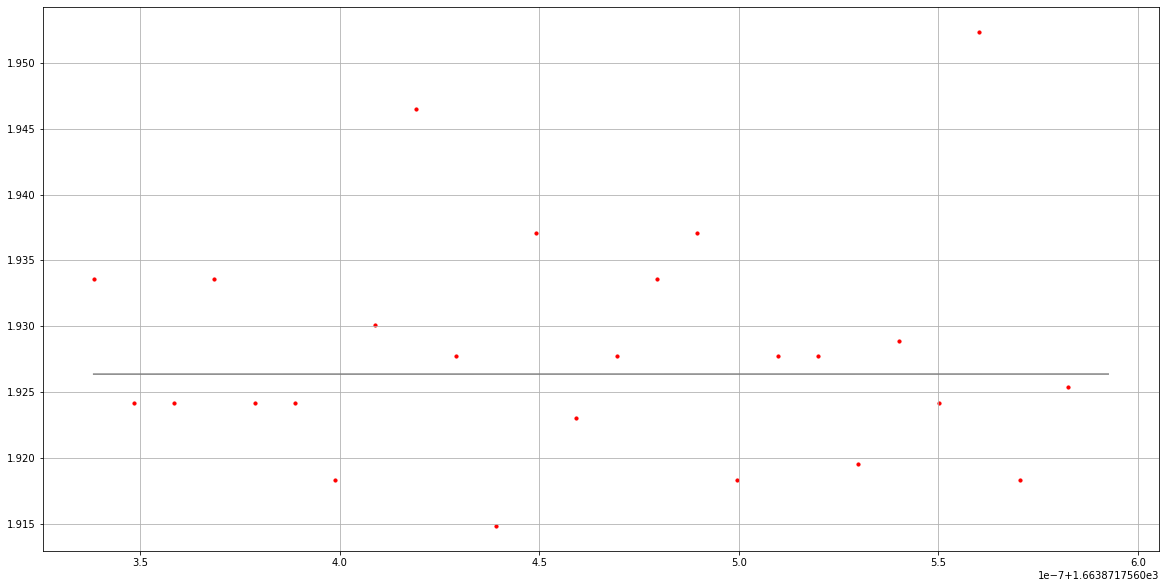

In [36]:

f = fit_sinus(ts, volt)

n = 25

plt.figure(figsize=(20, 10))
plt.scatter(ts[:n], volt[:n], c="red", s=10)

tss = np.linspace(ts[0], ts[n], 10_000)
plt.plot(tss, f(tss), c="grey")

plt.grid()
plt.show()

In [44]:
# time difference
a, b = np.min(ts) / 1_000_000, np.max(ts) / 1_000_000
datetime.fromtimestamp(b) - datetime.fromtimestamp(a)

datetime.timedelta(0)

In [47]:
ts[1]-ts[0]

1.0098801794811152e-08